imports and upload data
-----------

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
import colorcet as cc
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import scipy
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
mean_df = pd.read_csv(cpath+'/mean_df_female.csv')

UMAP preprocessing and functions
--------------------

In [3]:
import warnings

# Normalization
def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std

# Dimensionality reduction
def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        rows are sessions and columns are syllables
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

rearrrange data in structure
----------

In [4]:
# arrange all data in stcuture: 4 phases X 16 mice in each phase X n samples in session
mic = sorted(mean_df['mouse'].unique())
rep = sorted(mean_df['rep'].unique())
groups = sorted(mean_df['group'].unique())

# matrix per mouse
msessions=[]
mdbg = []
mmice=[]
mrep = []
mphase=[]
for indm, mc in enumerate(mic): # for all mice
    s1=[]
    rep1=[]
    smic1=[]
    m1=[]
    phase1=[]
    curr=mean_df.loc[(mean_df['mouse']==mc)] # find the current mouse in current phase
    #sor=np.argsort(curr['rep'].unique(),axis=0)
    #cs=curr['SubjectName'].unique()[sor]
    cs=curr['SubjectName'].unique()
    for inds, ss in enumerate(cs): #all session for a mouse
            syl = curr.loc[curr['SubjectName']==ss]['usage'].values
            s1.append(ss) #session name
            rep1.append(int(curr.loc[curr['SubjectName']==ss]['rep'].unique())) #repetition number
            smic1.append(syl) #syllable usafe
            m1.append(mc) #mouse
            phase1.append(str(curr.loc[curr['SubjectName']==ss]['group'].unique())) #phase
    mmice.append(m1) # 16 mics X n sessions 
    mdbg.append(smic1) #syllable usages 16 mice X n sessions X 61 syllables 
    msessions.append(s1) # 16 mice X sessions names
    mrep.append(rep1) # 16 mice X repetitions names
    mphase.append(phase1)

rep_labels = np.unique(np.concatenate(mrep))
mouse_labels = np.unique(np.concatenate(mmice))
group_labels = list(np.unique(np.concatenate(mphase)))

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [5]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")
phasec = ['#CE3045','#EF7C32','#FFDD00','#939598']
cmap2 = cc.glasbey

UMAP
-----------

In [6]:
# run umap analysis
frequencies = np.concatenate(mdbg)
coordinates = umap_embedding(frequencies.T, 
        standardize=True,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=8,
        random_state=0)

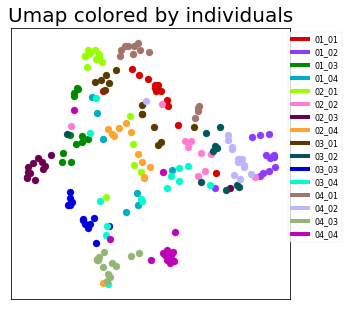

In [7]:
# plotting data colored by individuals
custom_lines=[]
# set the colors for the plot
for i in range(len(mouse_labels)):
    custom_lines.append(Line2D([0], [0], color=cmap2[i], lw=4))
le = LabelEncoder()
le.fit(np.unique(np.concatenate(mmice)))
y = le.transform(np.concatenate(mmice))
    
fig, ax = plt.subplots()
fig.set_size_inches(5,5) 
plt.legend(handles=custom_lines,labels=list(mouse_labels),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by individuals',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(), s=50)       
fig.savefig(data_loc + 'umap_indv.pdf', bbox_inches='tight')

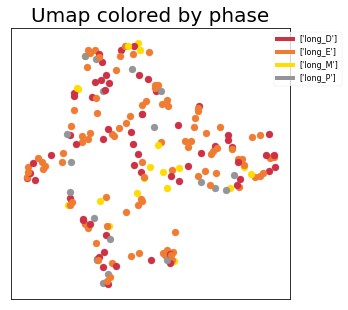

In [8]:
# plotting by phase
custom_lines=[]
# set the colors for the plot
age_labels = group_labels
for i in range(len(age_labels)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
le = LabelEncoder()
le.fit(np.unique(np.concatenate(mphase)))
y = le.transform(np.concatenate(mphase))
    
fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by phase',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(), s=50)
fig.savefig(data_loc + 'umap_phase.pdf', bbox_inches='tight')